# <u><center>SARIMA Models (Practice)
* Authored By: Eric N. Valdez
* Date: 2/13/2024

## `SARIMA Models`
For this assignment, you will be predicting energy consumption for the next 24 months. You will ultimately be comparing a seasonal and nonseasonal model.

You can access the data [here](https://drive.google.com/file/d/1IClDcGLYysTkFEOeSTYplNvxJgrk9wzL/view) ([Original Source](https://github.com/jenfly/opsd))

## `Imports and Custom Functions`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs, nsdiffs

In [2]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])

In [3]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)
    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')
    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )
    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)
    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")
        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 
        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")
    fig.tight_layout()
    
    return fig

In [4]:
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics

## `Load Data`

* We will look at the "Consuption" column for our time series.

In [6]:
# Loading Data frame
df = pd.read_csv('Data/opsd_germany_daily.csv')
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


* Convert the Date column to datetime and make it the index.

In [7]:
# Make the date column a datetime object and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.index

DatetimeIndex(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04',
               '2006-01-05', '2006-01-06', '2006-01-07', '2006-01-08',
               '2006-01-09', '2006-01-10',
               ...
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-28', '2017-12-29',
               '2017-12-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=4383, freq=None)

* Resample the data to a <u>monthly frequency</u> calculated with the mean

In [8]:
# The data is daily; resampling to Monthly using the mean
df = df.resample('M').mean()

In [9]:
# Defining the 'ts' with the energy consumption column
ts = df['Consumption']

* Check for and address missing values.

In [10]:
# Checking for null values
ts.isna().sum()

0

* Plot the time series

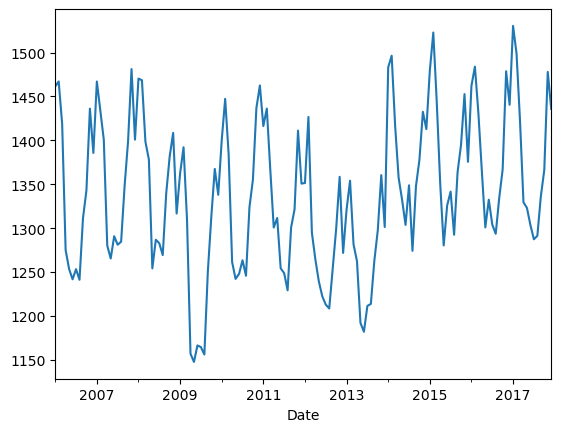

In [11]:
# Plotting and visulizing the time series
ts.plot();

### `ARIMA`

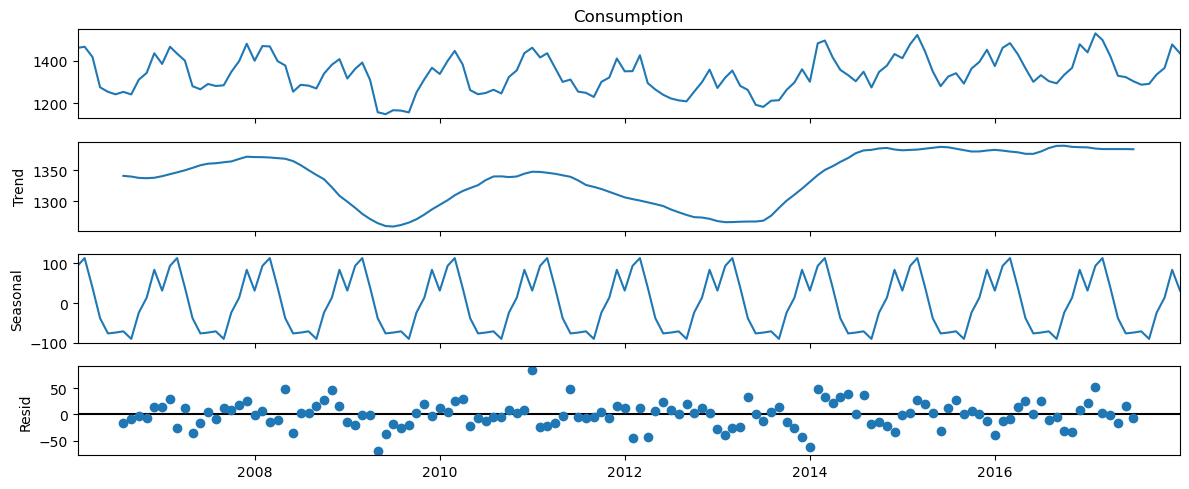

In [12]:
# We see a repeating pattern that is likely seasonal
# Apply seasonal decomposition
decomp = tsa.seasonal_decompose(ts)
fig = decomp.plot()
fig.set_size_inches(12,5)
fig.tight_layout()

In [14]:
# How big is the seasonal component
seasonal_delta = decomp.seasonal.max() - decomp.seasonal.min()

# How big is the seasonal component relative to the time series?
print(f"The seasonal component is {seasonal_delta} which is ~{seasonal_delta/(ts.max()-ts.min()) * 100 :.2f}% of the variation in time series.")

The seasonal component is 202.8199389305879 which is ~52.99% of the variation in time series.


* Use ndiffs to determine if nonseasonal differencing is required

In [15]:
# Checking for nonseasonal differencing 
ndiffs(ts)

0

In [16]:
# Check for seasonal differencing 
nsdiffs(ts, m = 12)

0

* Plot ACF and PACF to estimate initial orders

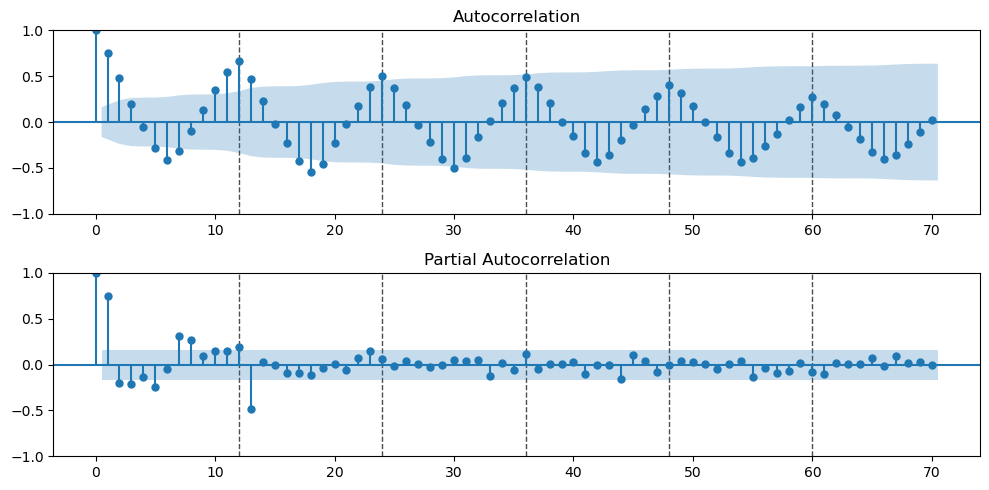

In [17]:
# We can use our function to highlight the seasonal lags by adding the arguments
plot_acf_pacf(ts, annotate_seas=True, m = 12, nlags = 70);

`Nonseasonal:` The ACF tapers while the PACF has a sharp drop after 1 lag start with AR(1) `Seasonal:` Harder to read. They both somewhat taper, let's start with 1,1

* Train test split the data using a test_size equal to the length of the final forecast (24 months) and visualize the result. 

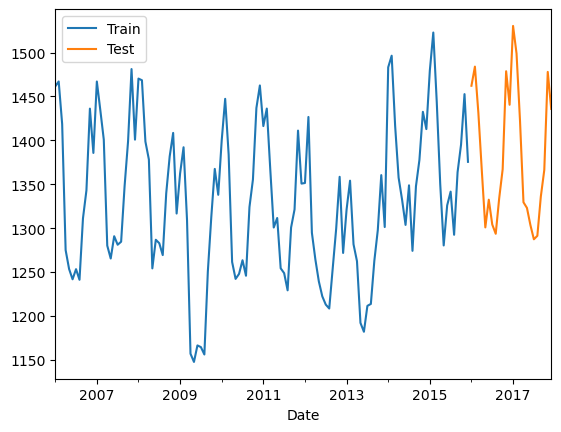

In [18]:
# tts so test size is 24 lags
test_lags = 24 
train, test = train_test_split(ts, test_size= test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

* Run an ARIMA model with the orders determined based on your EDA.

In [19]:
# Try a nonseasonal model
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

arima = tsa.ARIMA(train, order = (p,d,q)).fit()

# Obtain summary
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  120
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -653.886
Date:                Tue, 13 Feb 2024   AIC                           1313.773
Time:                        04:00:59   BIC                           1322.135
Sample:                    01-31-2006   HQIC                          1317.169
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1334.9675     20.412     65.401      0.000    1294.961    1374.974
ar.L1          0.7558      0.074     10.171      0.000       0.610       0.901
sigma2      3143.5980    412.704      7.617      0.000    2334.713    3952.484
===================================================================================
Ljung-Box (L1) (Q):                   2.44   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.12   Prob(JB):                         0.99
Heteroskedasticity (H):               0.87   Skew:                             0.02
Prob(H) (two-sided):                  0.65   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Obtain the model summary, plot diagnostics, plot the forecasts with confidence intervals, and obtain regression metrics for ARIMA model.

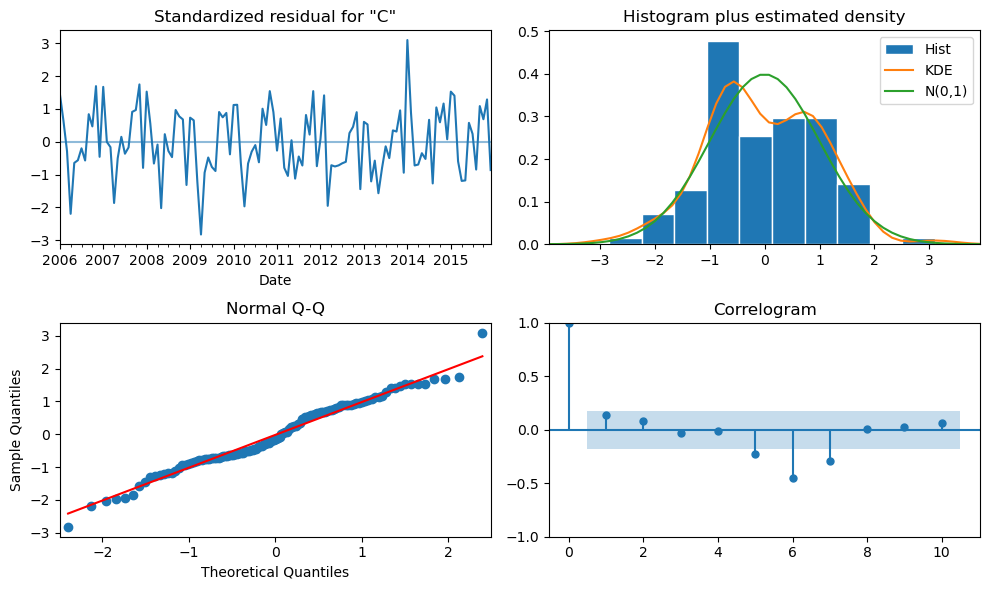

In [20]:
# Obtain diagnostic plots
fig = arima.plot_diagnostics()
fig.set_size_inches(10,6)
fig.tight_layout()

### There are significant lags in the correlation of residuals -- in this case we know that we have not included the seasonal component

### `SARIMA`

* Use nsdiffs to determine if seasonal differencing is required 

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 66.492
- MSE = 7,412.715
- RMSE = 86.097
- R^2 = -0.279
- MAPE = 4.63%


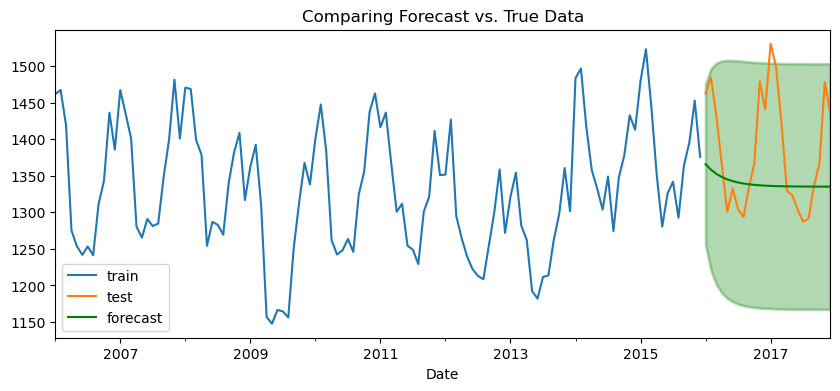

In [21]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = arima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

### Visually, it is clear that the forecast does not capture any of the seasonal fluctations.

* Apply seasonal decomposition to the data 

* Plot the seasonal component to determine 'm'.

* Determine the size and relative size of 'm'.

* Examine the seasonal lags of the ACF / PACF to determine seasonal orders

* Run SARIMA model with the orders determined based on you EDA.

In [26]:
# Orders for non seasonal components
p = 1  # nonseasonal AR
d = 0  # nonseasonal differencing
q = 0  # nonseasonal MA

# Orders for seasonal components
P = 1  # Seasonal AR
D = 0  # Seasonal differencing
Q = 1  # Seasonal MA
m = 12 # Seasonal period

sarima = tsa.ARIMA(train, order = (p,d,q), seasonal_order=(P,D,Q,m)).fit()

# Obtain summary
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        Consumption   No. Observations:                  120
Model:             ARIMA(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                -602.870
Date:                            Tue, 13 Feb 2024   AIC                           1215.739
Time:                                    04:09:19   BIC                           1229.677
Sample:                                01-31-2006   HQIC                          1221.399
                                     - 12-31-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1330.7444     57.821     23.015      0.000    1217.417    1444.072
ar.L1          0.7880      0.058     13.540      0.000       0.674       0.902
ar.S.L12       0.9954      0.011     91.794      0.000       0.974       1.017
ma.S.L12      -0.8619      0.157     -5.485      0.000      -1.170      -0.554
sigma2      1088.5553    201.607      5.399      0.000     693.413    1483.697
===================================================================================
Ljung-Box (L1) (Q):                   4.23   Jarque-Bera (JB):                23.67
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.37
Prob(H) (two-sided):                  0.91   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

* Obtain the model summary, plot diagnostics, plot the forecasts with confidence intervals, and obtain regression metrics for the ARIMA model.

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 46.229
- MSE = 2,687.689
- RMSE = 51.843
- R^2 = 0.536
- MAPE = 3.30%


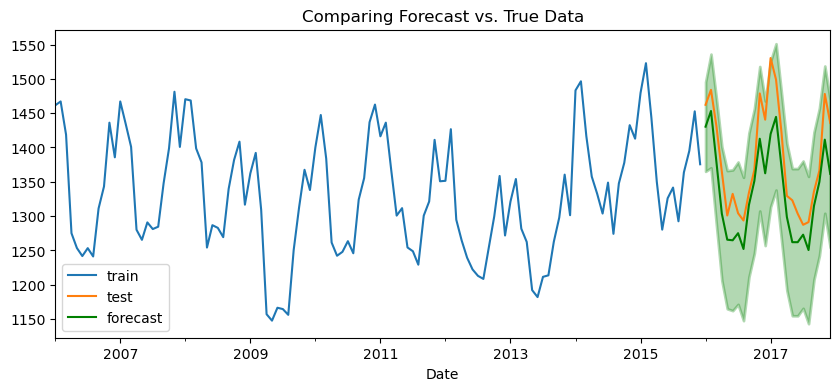

In [25]:
# Obtain forecast as a dataframe with confidence intervals
forecast_df = sarima.get_forecast(steps=len(test)).summary_frame()
# Call the custom function to plot the forecasts with confidence intervals and true values
plot_forecast(train, test, forecast_df);
# Obtain metrics
regression_metrics_ts(test, forecast_df['mean'])

* `Notice` how adding a seasonal component improves this model.

* The seasonal model follows the general seasonal cycles.
* 
The seasonal model also has lower AIC score and preferred values for regression metrics